## 대출 상환 예측 데이터
* https://www.kaggle.com/c/home-credit-default-risk

* 고객 정보를 기반으로 대출 상환 가능 여부 예측(0이면 상환 가능, 1이면 상환 불가능)
* 메인 테이블(application_train, application_test)만 사용 예정

```
많은 사람들이 신용 기록이 부족하거나 존재하지 않아 대출을 받기 위해 애쓴다. 그리고 불행하게도, 이 인구는 종종 신뢰할 수 없는 대출자들에 의해 이용된다.

홈 크레딧은 긍정적이고 안전한 대출 경험을 제공함으로써 비은행 인구에 대한 금융 포함을 확대하기 위해 노력하고 있다. 이러한 소외된 인구가 긍정적인 대출 경험을 가질 수 있도록 하기 위해 Home Credit은 전화 회사 및 거래 정보를 포함한 다양한 대체 데이터를 사용하여 고객의 상환 능력을 예측한다.

Home Credit은 현재 이러한 예측을 위해 다양한 통계 및 기계 학습 방법을 사용하고 있지만, Kagglers가 데이터의 잠재력을 최대한 활용할 수 있도록 지원하는 데 도움을 주고 있다. 이렇게 함으로써 상환 능력이 있는 고객은 거절당하지 않고, 대출이 원금, 만기 및 상환 달력에 따라 제공하게 하므로 고객들에게 맞춤형 대출 서비스를 제공할 수 있다.
```

#### 목적)
- EDA를 통한 데이터 탐색

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## import 라이브러리

In [ ]:
# 데이터 가공을 위한 numpy, pandas import
import numpy as np
import pandas as pd

# 범주형 변수를 처리하는 등의 전처리과정을 위한 sklearn import
from sklearn.preprocessing import LabelEncoder

# file system 관리
import os

# 경고 방지
import warnings
warnings.filterwarnings('ignore')

# 시각화를 위한 matplotlib, seaborn import
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 사용 가능한 파일 목록 확인
print(os.listdir("../input/"))

#### 각 라이브러리의 내장함수에 대해 알고싶다면 공식 문서를 참고해보자!!

- https://pandas.pydata.org/docs/index.html

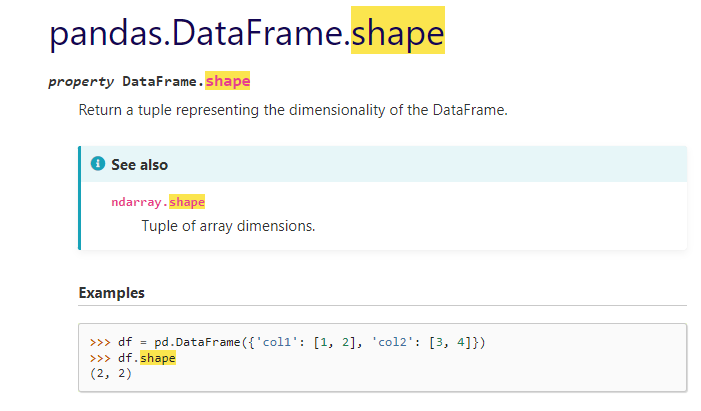

In [ ]:
# Training data
train_data = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
print('Training data shape: ', train_data.shape)
train_data.head()

### Train_Data 정리
- 307511개의 122개의 항목에 대한 데이터
- 행은 307511개
- 열은 122개
* 즉, shape 함수는 (index,columns) 값을 출력한다.

In [ ]:
# Testing data 
test_data = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', test_data.shape)
test_data.head()

---
## EDA

## 1) TARGET 컬럼 확인
0이면 상환 가능, 1이면 상환이 불가능을 의미

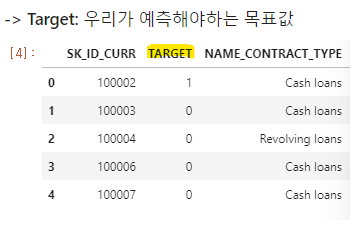


In [ ]:
train_data['TARGET'].value_counts()

### 정리
- 0: 282686개
- 1: 24825개
- dataType: int64

In [ ]:
train_data['TARGET'].astype(int).plot.hist();

#### 정리
- 0이 1값보다 많음!!
- 즉, **대출을 상환할 수 있는 대상**이 많은 것을 알 수 있다.

## 2) 결측치 확인
각 컬럼의 결측치 개수 및 비중 확인

In [ ]:
# 결측치 개수 확인
mis_val=train_data.isnull().sum()

# 결측치 비중 확인 (null개수/총 개수)*100
mis_val_percent = 100*train_data.isnull().sum()/len(train_data)

# 결측치 개수, 결측치 비중 테이블 만들기
# concat 여러 개의  동일한 형태 DataFrame 합치기 axis = 0 위+아래, axis = 1 좌-우 
mis_val_table=pd.concat([mis_val, mis_val_percent],axis=1) # axis = 1 좌-우 

# 컬럼 이름바꾸기 rename(인덱스:이름,~~)
mis_val_table_ren_columns = mis_val_table.rename(columns={0:'Missing Values',1:'% of Total Values'})
                                                    
# 결측치 0인 컬럼은 제외하고 정렬
# iloc 은 integer location의 약어로, 데이터 프레임의 행이나 칼럼의 순서를 나타내는 정수로 특정 값을 추출해준다. 오름차순 x => 내림차순
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=0].sort_values('% of Total Values',ascending=False).round(1)

mis_val_table_ren_columns

* 67개의 컬럼에 결측치가 포함되어있다.
* 위의 결측치들을 채워야한다.(imputation)
* 결측치가 너무 많은 컬럼은 삭제할 수도 있지만, 모델 성능에 도움이 될 수도 있기 때문에 우선 유지

## 3) Column Types
int64,float64 타입은 수치형 변수, object 타입은 범주형 변수

In [ ]:
train_data.dtypes.value_counts()

In [ ]:
# 범주형 변수에서 Unique 값의 개수
# app_train.select_dtypes('object').apply(pd.Series.nunique) 
# nunique 고유값들의 수를 출력해줌
train_data.select_dtypes('object').nunique() # apply 함수 없이 가능

* OCCUPATION_TYPE과 ORGANIZATION_TYPE을 제외하면 범주형 변수는 유니크한 값이 적음

## 4) 범주형 변수 Encoding
LightGBM같은 모델을 제외하고 대부분의 머신러닝 모델은 범주형 변수를 다룰 수 없기 때문에, 이러한 범주형 변수를 encode 해줘야한다. 그 방법으로는 아래 두가지가 있다.

1) Lable Encoding:
 * 범주형 변수의 개별값을 숫자로 바꿔주는 방법. 컬럼을 새로 생성하지 않음
 * 여성/남성 처럼 범주형 변수의 값이 두개일 경우는 Label Encoding을 사용해도 무관하지만, 그 이상일 경우는 One-Hot Enconding을 사용하는 것이 좋음
 
2) One-Hot Encoding:
 * 피처 값의 유형에 따라 새로운 피처를 추가해 고유값에 해당하는 컬럼에만 1을 표시하고 나머지 컬럼에는 0을 표시하는 방법
 * One-Hot Encoding의 경우 범주형 변수의 유니크한 값의 개수만큼 컬럼이 늘어난다는 것(이를 보완하기 위해 PCA같은 차원축소 방법을 사용할 수도 있음)

이 노트북에서는 범주형 변수의 유니크한 값이 2개일 경우 Label Encoding을 사용하고 그 이상일 경우 One-Hot Encoding을 사용할 것이다.

### Label Encoding and One-Hot Encoding

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# 대상: 데이터타입이 object이고 값의 종류가 두개 이하일경우
le = LabelEncoder()
le_count = 0

# 컬럼별로 iterate 돌기
for col in train_data:
    if train_data[col].dtype=='object':
        # 데이터 타입이 object이고, 값의 종류가 두개 이하일 경우,
        if len(list(train_data[col].unique())) <=2:
            
            # train과 test에 동일하게 라벨 인코딩을 하기 위해 train 기준으로 fit한 값을 train, test에 동일하게 transform
            le.fit(train_data[col])
            
            # train-set, test-set 모두 Transform
            train_data[col]=le.transform(train_data[col])
            test_data[col]=le.transform(test_data[col])
            
            # Label Encoding을 한 컬럼이 몇개인지 카운트
            le_count+=1
print('%d columns were label encoded.' % le_count)

In [ ]:
# 위에서 Label-encoding적용 안한 나머지 범주형 변수에 One-hot encoding 적용
# 값이 두 가지 이상인 object 데이터타입에 해당하는 변수
# get_dummies -> 결측치를 제외하고 0과 1로 구성된 더미값이 만들어진다.
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

print('Training Features shape: ', train_data.shape)
print('Testing Features shape: ', test_data.shape)

## 5) Train data와 Test data 컬럼 맞춰주기
train 데이터와  test 데이터에는 동일한 feature가 있어야한다.
train 데이터에 있는 카테고리 변수의 유니크한 값 개수와 test 데이터에 있는 카테고리 변수의 유니크한 값 개수가 다른 변수들이 있어서 One-Hot Encoding을 했더니, train에는 있는데 test에는 없는 컬럼들이 생겨버림

따라서 test 데이터에는 없고 train에만 있는 컬럼을 삭제(TARGET 컬럼은 제외)

In [ ]:
# TARGET변수는 train데이터에만 있지만 필요한 변수이기때문에 따로 빼두고나서 다시추가할것
train_labels=train_data['TARGET']

"""
두 데이터프레임에 모두 있는 컬럼들만 유지하면서 train-set과 test-set을 align한다.
즉, train 데이터와 test 데이터에 둘다 있는 컬럼들의 값만 가져오려는것
"""

train_data, test_dat = train_data.align(test_data,join='inner',axis=1)

# TARGET변수 다시 추가
train_data['TARGET']=train_labels

print('Training Features shape: ', train_data.shape)
print('Testing Features shape: ', test_data.shape)

## 6) 이상치(Anomalies)
*  HOW?? describe() 메소드로 컬럼의 통계값들을 보는 것이다,


```
1. [SK_ID_CURR] ID of loan in our sample, 대출 ID
2. [TARGET] 0: 지불할 수 있는 고객 1: 지불에 어려움을 겪는 고객: 첫 대출 금액 Y의 적어도 일부분에 대해 X날 이상 지불이 늦음 
5. [NAME_CONTRACT_TYPE] Identification if loan is cash or revolving, 대출이 현금인지 리볼빙인지
*리볼빙: 약정된 결제일에 최소 금액만 결제하고 나머지 대금은 대출로 이전하는 방식
6. [CODE_GENDER] Gender of the client, 성별[F/M/XNA]
7. [FLAG_OWN_CAR] Flag if the client owns a car, 차 소유 여부[Y/N]
8. [FLAG_OWN_REALTY] Flag if client owns a house or flat, 집/아파트 보유 여부[Y/N]
9. [CNT_CHILDREN] Number of children the client has, 자녀수
10. [AMT_INCOME_TOTAL] Income of the client, 수입
11. [AMT_CREDIT] Credit amount of the loan, 대출 총액
12. [AMT_ANNUITY] Loan annuity, 매달 내야하는 돈(이자 포함)
13. [AMT_GOODS_PRICE] For consumer loans it is the price of the goods for which the loan is given, 대출받아서 사려고 한 상품 총액
14. [NAME_TYPE_SUITE] Who was accompanying client when he was applying for the loan, 대출 신청시 동행인
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' 'NAN' 'Other_B' 'Group of people']
15. [NAME_INCOME_TYPE] "Clients income type (businessman, working, maternity leave,... )", 소득 타입
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed' 'Student' 'Businessman' 'Maternity leave']
16. [NAME_EDUCATION_TYPE] Level of highest education the client achieved, 최종 학력 수준
['Secondary / secondary special' 'Higher education' 'Incomplete higher' 'Lower secondary' 'Academic degree']
17. [NAME_FAMILY_STATUS] Family status of the client, 가족 현황
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated' 'Unknown']
18. [NAME_HOUSING_TYPE] "What is the housing situation of the client (renting, living with parents, ...)", 주거 현황
['House / apartment' 'Rented apartment' 'With parents' 'Municipal apartment' 'Office apartment' 'Co-op apartment']
19. [REGION_POPULATION_RELATIVE] Normalized population of region where client lives (higher number means the client lives in more populated region),normalized, 고객 거주 지역의 정규화된 인구수(높을수록 인구수 많음)
20. [DAYS_BIRTH] Client's age in days at the time of application,time only relative to the application, 신청날 고객 나이
21. [DAYS_EMPLOYED] How many days before the application the person started current employment,time only relative to the application, 신청일 기준 현재 직장에서 일한 일 수
22. [DAYS_REGISTRATION] How many days before the application did client change his registration,time only relative to the application, 고객이 등록서류를 변경한 일 수, 신청일 기준
23. [DAYS_ID_PUBLISH] How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application, 고객이 대출을 신청한 동안에 신분증 문서를 변경한 일수, 신청일 기준
24. [OWN_CAR_AGE] Age of client's car, 고객 자동차 연식
25. [FLAG_MOBIL] "Did client provide mobile phone (1=YES, 0=NO)", 고객 휴대폰 번호 제공 여부
26. [FLAG_EMP_PHONE] "Did client provide work phone (1=YES, 0=NO)", 고객 직장 번호 제공 여부
27. [FLAG_WORK_PHONE] "Did client provide home phone (1=YES, 0=NO)", 고객 자택 번호 제공 여부
28. [FLAG_CONT_MOBILE] "Was mobile phone reachable (1=YES, 0=NO)", 고객 휴대폰 연결 가능 여부
29. [FLAG_PHONE] "Did client provide home phone (1=YES, 0=NO)", 고객 자택 번호 제공 여부
30. [FLAG_EMAIL] "Did client provide email (1=YES, 0=NO)", 고객 이메일 제공 여부
31. [OCCUPATION_TYPE] What kind of occupation does the client have, 고객 직업
32. [CNT_FAM_MEMBERS] How many family members does client have, 고객 가족 구성원 수
33. [REGION_RATING_CLIENT] "Our rating of the region where client lives (1,2,3)", 고객이 사는 지역에 대한 우리의 평가(1, 2, 3)
34. [REGION_RATING_CLIENT_W_CITY] "Our rating of the region where client lives with taking city into account (1,2,3)", 고객이 사는 도시에 대한 우리의 평가(1, 2, 3)
35. [WEEKDAY_APPR_PROCESS_START] On which day of the week did the client apply for the loan, 대출 신청 요일
36. [HOUR_APPR_PROCESS_START] Approximately at what hour did the client apply for the loan,rounded, 대출 신청한 대략적인 시각
37. [REG_REGION_NOT_LIVE_REGION] "Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)", 고객 영구 주소와 획득 주소가 일치하는지(지역)
38. [REG_REGION_NOT_WORK_REGION] "Flag if client's permanent address does not match work address (1=different, 0=same, at region level)", 고객 영구 주소와 직장 주소가 일치하는지
39. [LIVE_REGION_NOT_WORK_REGION] "Flag if client's contact address does not match work address (1=different, 0=same, at region level)", 고객 획득 주소와 직장 주소가 일치하는지
40. [REG_CITY_NOT_LIVE_CITY] "Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)", 고객 영구 주소와 획득 주소가 일치하는지(도시)
41. [REG_CITY_NOT_WORK_CITY] "Flag if client's permanent address does not match work address (1=different, 0=same, at city level)", 고객 영구 주소와 직장 주소가 일치하는지
42. [LIVE_CITY_NOT_WORK_CITY] "Flag if client's contact address does not match work address (1=different, 0=same, at city level)", 고객 획득 주소와 직장 주소가 일치하는지
43. [ORGANIZATION_TYPE] Type of organization where client works, 고객이 일하는 조직의 유형
44. [EXT_SOURCE_1] Normalized score from external data source,normalized, 외부 데이터 소스의 정규화된 점수
45. [EXT_SOURCE_2] Normalized score from external data source,normalized
46. [EXT_SOURCE_3] Normalized score from external data source,normalized
47 ~ 93. "Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized, 고객이 거주하는 곳에 대한 표준화된 정보, 아파트 사이즈, 공용지, 주거지, 빌딩 나이, 엘리베이터 수, 입구 수, 빌딩 상태, 층 수 등에 대한 평균(_AVG suffix), 최빈값(_MODE suffix), 중앙값 (_MEDI suffix)
  - 47~60 평균(_AVG suffix)
[APARTMENTS_AVG] [BASEMENTAREA_AVG] [YEARS_BEGINEXPLUATATION_AVG] [YEARS_BUILD_AVG] [COMMONAREA_AVG] [ELEVATORS_AVG] [ENTRANCES_AVG] [FLOORSMAX_AVG] [FLOORSMIN_AVG] [LANDAREA_AVG] [LIVINGAPARTMENTS_AVG] [LIVINGAREA_AVG] [NONLIVINGAPARTMENTS_AVG] [NONLIVINGAREA_AVG]
  - 61~74 최빈값(_MODE suffix)
[APARTMENTS_MODE] [BASEMENTAREA_MODE] [YEARS_BEGINEXPLUATATION_MODE] [YEARS_BUILD_MODE] [COMMONAREA_MODE] [ELEVATORS_MODE] [ENTRANCES_MODE] [FLOORSMAX_MODE] [FLOORSMIN_MODE] [LANDAREA_MODE] [LIVINGAPARTMENTS_MODE] [LIVINGAREA_MODE] [NONLIVINGAPARTMENTS_MODE] [NONLIVINGAREA_MODE]
  - 75~88 중앙값 (_MEDI suffix)
[APARTMENTS_MEDI] [BASEMENTAREA_MEDI] [YEARS_BEGINEXPLUATATION_MEDI] [YEARS_BUILD_MEDI] [COMMONAREA_MEDI] [ELEVATORS_MEDI] [ENTRANCES_MEDI] [FLOORSMAX_MEDI] [FLOORSMIN_MEDI] [LANDAREA_MEDI] [LIVINGAPARTMENTS_MEDI] [LIVINGAREA_MEDI] [NONLIVINGAPARTMENTS_MEDI] [NONLIVINGAREA_MEDI]
  - 89~93 최빈값(_MODE suffix)
[FONDKAPREMONT_MODE] [HOUSETYPE_MODE] [TOTALAREA_MODE] [WALLSMATERIAL_MODE] [EMERGENCYSTATE_MODE]
94. [OBS_30_CNT_SOCIAL_CIRCLE] How many observation of client's social surroundings with observable 30 DPD (days past due) default, 고객 주위 사람 중 30일 이상 지불이 늦을 수 있는 사람의 수
95. [DEF_30_CNT_SOCIAL_CIRCLE] How many observation of client's social surroundings defaulted on 30 DPD (days past due), 해당 고객 주위 사람 중 30일 이상 지불이 정말 늦은 사람의 수
96. [OBS_60_CNT_SOCIAL_CIRCLE] How many observation of client's social surroundings with observable 60 DPD (days past due) default, 해당 고객 주위 사람 중 60일 이상 지불이 늦을 수 있는 사람의 수
97. [DEF_60_CNT_SOCIAL_CIRCLE] How many observation of client's social surroundings defaulted on 60 (days past due) DPD, 해당 고객 주위 사람 중 60일 이상 지불이 정말 늦은 사람의 수
98. [DAYS_LAST_PHONE_CHANGE] How many days before application did client change phone, 대출 신청 며칠 전에 휴대폰을 변경했는가?
99 ~118. Did client provide document 2 ~ 21, 고객 문서 제공 횟수
[FLAG_DOCUMENT_2] [FLAG_DOCUMENT_3] [FLAG_DOCUMENT_4] [FLAG_DOCUMENT_5] [FLAG_DOCUMENT_6] [FLAG_DOCUMENT_7] [FLAG_DOCUMENT_8] [FLAG_DOCUMENT_9] [FLAG_DOCUMENT_10] [FLAG_DOCUMENT_11] [FLAG_DOCUMENT_12] [FLAG_DOCUMENT_13] [FLAG_DOCUMENT_14] [FLAG_DOCUMENT_14] [FLAG_DOCUMENT_15] [FLAG_DOCUMENT_16] [FLAG_DOCUMENT_17] [FLAG_DOCUMENT_18] [FLAG_DOCUMENT_19] [FLAG_DOCUMENT_20] [FLAG_DOCUMENT_21]
119. [AMT_REQ_CREDIT_BUREAU_HOUR] ,Number of enquiries to Credit Bureau about the client one hour before application, 신청 전 1시간 고객에 대한 CB로의 문의 횟수
120. [AMT_REQ_CREDIT_BUREAU_DAY] Number of enquiries to Credit Bureau about the client one day before application (excluding one hour before application), 신청 전 하루동안 고객에 대한 CB로의 문의 횟수(1시간 전 제외)
121. [AMT_REQ_CREDIT_BUREAU_WEEK] Number of enquiries to Credit Bureau about the client one week before application (excluding one day before application), 신청 전 일주일동안 고객에 대한 CB로의 문의 횟수(하루 전 제외)
122. [AMT_REQ_CREDIT_BUREAU_MON] Number of enquiries to Credit Bureau about the client one month before application (excluding one week before application), 신청 전 한 달동안 고객에 대한 CB로의 문의 횟수(일주일 전 전 제외)
123. [AMT_REQ_CREDIT_BUREAU_QRT] Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application), 신청 전 세 달 동안 고객에 대한 CB로의 문의 횟수(한 달 전 제외)
124. [AMT_REQ_CREDIT_BUREAU_YEAR] Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application), 신청 전 일년 동안 고객에 대한 CB로의 문의 횟수(세 달 전 제외)
```

In [ ]:
# DAYS_BIRTH: 신청일 기준 나이(이상치 없어보임)
(train_data['DAYS_BIRTH']/-365).describe()

In [ ]:
# DAYS_EMPLOYED: 신청일 기준 현재 직장에서 일한 일 수(이상치)
train_data['DAYS_EMPLOYED'].describe()

In [ ]:
# 더 자세히 살펴보기 위해 히스토그램 그리기
train_data['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

이상치인것 같은 고객들은 따로 빼서 그들의 대출상환 비율이 그외의 고객들에비해 높거나 낮은 경향이 있는지 파악해보자

In [ ]:
# 이상치
anom=train_data[train_data['DAYS_EMPLOYED']==365243]
# 이상치 외
non_anom=train_data[train_data['DAYS_EMPLOYED']!=365243]

# Target 평균을 보고 이상치에 해당하는 사람들에 대한 데이터 추출
print('The non-anomalies default on %0.2f%% of loans' %(100*non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

* 이상치로 보이는 고객들이 대출을 상환하지못할 확률이 5.4%로 더 낮음.
* 이상치를 다루는 가장 안전한 방법은 결측치 채우듯이 채우는 방법
* 이 경우 모든 이상치들이 같은값을 갖고 있으므로, 다 같은 값으로 채울것이다.
* 이상값들이 중요해보이니, 머신러닝 모델에 이 이상값들을 임의로 채운것에대해 알려줄것이다.

> 결론적으로
    * 이상값을 숫자로 채우지 않고, 새로운 boolean 컬럼을 만들어서 이상값인지 아닌지를 구분할것이다.

In [ ]:
# Create an anomalous flag column
## 이상치(365243)인 값에 대해서 True , False로 구분
train_data['DAYS_EMPLOYED_ANOM'] = train_data["DAYS_EMPLOYED"] == 365243

# 이상치를 nan값으로 대치
# inplace 옵션이 True이면,  명령어를 실행 한 후 메소드가 적용된 데이터 프레임으로 반환 한다. 
# 즉, 삭제 메소드를 실행했다면 반환값은 컬럼이 삭제된 Dataframe이 된다. 
train_data['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True)

train_data['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram');
plt.xlabel('Days Employment');

In [ ]:
# test data에도 train data와 동일하게 작업
# test 데이터에도 train 데이터와 동일하게 작업
test_data['DAYS_EMPLOYED_ANOM']=test_data['DAYS_EMPLOYED']==365243
test_data['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)

# True, False로 되어있는 데이터 sum하면 True인것 개수 카운팅됨.
print('There are %d anomalies in the test data out of %d entries'%(test_data['DAYS_EMPLOYED_ANOM'].sum(), len(test_data)))

## 7) Correlation
* 카테고리형 변수와 Outlier
* 데이터를 이해하는 방법 중 하나는 변수간, 그리고 Target과의 상관관계를 살펴보는 것
* .corr()를 사용해서 변수간, 그리고 Target 변수와의 Pearson 상관관계를 살펴보자

In [ ]:
# TARGET 변수왕의 상관관계
correlations = train_data.corr()['TARGET'].sort_values()

print('Most Positive Correlations: \n', correlations.tail(15))
print('\nMost Negative Correlations: \n', correlations.head(15))

* DAYS_BIRTH 컬럼이 가장 양의 상관성이 높다. 그러나 이 변수의 값들은 실제로 음수이다.
* 이 의미는 고객의 나이가 많을수록 대출 상환 가능성이 적다라는 것을 의미하고, 이는 DAYS_BIRTH가 음수이기 때문이다. 따라서, DAYS_BIRTH에 절대값을 취해서 다시 상관관계를 확인하려고 한다.

In [ ]:
# DAYS_BIRTH의 절대값과 TARGET 변수와의 상관계수
train_data['DAYS_BIRTH']=abs(train_data['DAYS_BIRTH'])
train_data['DAYS_BIRTH'].corr(train_data['TARGET'])

* 절대값을 취해서 다시 TARGET과의 상관계수를 보니 고객의 나이가 많을 수록 대출을 상환할 가능성이 높다고 나옴

In [ ]:
plt.style.use('fivethirtyeight')

# 고객 나이에 대한 히스토그램 분포 확인
plt.hist(train_data['DAYS_BIRTH']/365, edgecolor='k',bins=25)
plt.title('Age of Client');
plt.xlabel('Age (years)');
plt.ylabel('Count');

* 위의 분포를 살펴보니 outlier없이 나이가 고르게 분포되어있는 편. 
* 이제 나이가 TARGET에 미치는 영향을 시각화해서 보기위해 KDE plot을 그려볼것이다.

#### KDE plot을 사용하는 이유
* 보통 분포를 확인할 때 히스토그램을 많이 활용한다. 그런데 히스토그램은 구간을 어떻게 설정하냐에 따라 결과물이 매우 달라져서 엉뚱한 결론과 해석을 내릴 수 있음
* 그래서 그 대안으로 커널 밀도 추정(KDE) 그래프를 많이 사용함.
* 히스토그램 같은 분포를 곡선화해서 나타낸 그래프

In [ ]:
plt.figure(figsize=(10,8))

# 제때 대출을 상환하는 고객의 나이 plot (TARGET=0: 파란색)
sns.kdeplot(train_data.loc[train_data['TARGET']==0,'DAYS_BIRTH']/365,label='target==0')

# 제때 대출을 상환하지못하는 고객의 나이 plot (TARGET=1: 빨간색)
sns.kdeplot(train_data.loc[train_data['TARGET']==1,'DAYS_BIRTH']/365,label='target==1')

plt.xlabel('Age(years)');
plt.ylabel('Density');
plt.title('Distribution of Ages');

* target==1(빨간색)의 분포를 보면 20-30대에 기울어 있는것을 볼 수 있다. 이는 젊은 층일수록 대출 상환을 못할 확률이 높다고 유추할 수 있음.
* target==0일때와 1일때의 TARGET과의 분포가 상이한것으로 보아 이 변수는 머신러닝 모델에 유용하게 활용될 것으로 보인다.
* 그럼이제 나이를 나이대 별로 그룹을 나눠서 target=1(대출 상환이 어려운) 의 평균값을 살펴보자.

In [ ]:
# 최소 20 최대 70으로해서 총 10개로 그룹핑
## 결과는 20이상 25미만, 25이상 30미만,,,, 으로 그룹핑됨. 단 (,)는 포함 [,]는 미포함을 의미
np.linspace(20,70,num=11)

In [ ]:
"""
cut() 함수를 사용해서 5살 간격으로 나이대 그룹을 나눠보자. 
그다음, 각 나이대 별로 대출상환을 못하는 비율을 체크
"""

age_data=train_data[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH']=age_data['DAYS_BIRTH']/365

# Bin the age data
age_data['YEARS_BINNED']=pd.cut(age_data['YEARS_BIRTH'],bins=np.linspace(20,70,num=11))
age_data.head(10)

In [ ]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

In [ ]:
plt.figure(figsize=(8,8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation=75);
plt.xlabel('Age Group (years)');
plt.ylabel('Failur to Reapy(%)')
plt.title('Failure to Repay by Age Group');

* 젊은층일수록 대출을 상환하지 못하는 것으로 나타남
* 20-25세, 25-30세 30-35세는 각각 약 10% 이상 대출을 상환하지 못했고, 55-60세, 60-65세, 65-70세는 5%이하로 대출을 상환하지 못했음.

## 8) Exterior Sources
* 음의 상관이 가장 높았던 3개의 변수 EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 이다.
* 이 변수들은 외부에서 가져온 정규화된 score를 나타낸다.
* 그럼, 이제 TARGET 변수와 EXT_SOURCE와의 상관관계와 EXT_SOURCE 서로간의 상관관계를 살펴보자

In [ ]:
ext_data=train_data[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
ext_data_corrs=ext_data.corr()
ext_data_corrs

In [ ]:
plt.figure(figsize=(8,6))

sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap');

* EXT_SOURCE와 TARGET 변수는 음의 상관성을 띄므로, EXT_SOURCE값이 증가할수록 대출 상환을 잘한다는 의미로 해석가능.
* 또한, DAYS_BIRTH 변수는 EXT_SOURCE_1 변수와 양의 상관성이 높은것으로 보아 이 score중 하나는 고객의 나이일것으로 추정된다.
* 그 다음은 각 EXT_SOURCE 를 TARGET값 별로 나눠서 분포를 살펴보자.

In [ ]:
plt.figure(figsize=(10,12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']):
    plt.subplot(3,1,i+1)
    
    sns.kdeplot(train_data.loc[train_data['TARGET']==0,source],label='target==0')
    sns.kdeplot(train_data.loc[train_data['TARGET']==1,source],label='target==1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' %source);
    plt.ylabel('Density');
plt.tight_layout(h_pad=2.5)

* EXT_SOURCE_3 변수는 target값에 따라 차이가 가장 큰것으로 보인다.
* target 과의 상관계수가 그리 높지는 않지만, target이 0인지 1인지에 따라 값이 다른것으로 보아 모델에 영향을 주는 주요 변수라고 판단할 수 있음.

## 9) Pairs Plot
* EXT_SOURCE 와 DAYS_BIRTH 변수간의 pair plot을 그려보자. 
* pair plot은 각각의 분포를 보여줄 뿐만 아니라, 여러 변수간의 관계도 보여주는 좋은 시각화이다.

In [ ]:
# Copy the data for plotting
plot_data=ext_data.drop(columns=['DAYS_BIRTH']).copy()

# 고객 나이 컬럼 추가
plot_data['YEARS_BIRTH']=age_data['YEARS_BIRTH']

# 결측치 drop
plot_data=plot_data.dropna().loc[:100000,:]

# 두 컬럼 간의 상관관계를 계산하는 함수 작성
def corr_func(x,y,**kwargs):
    r=np.corrcoef(x,y)[0][1]
    ax=plt.gca()
    ax.annotate("r={:.2f}".format(r),
               xy=(.2, .8),
               xycoords=ax.transAxes,
               size=20)

# Create the pairgrid object
## vars = 변수명 리스트
grid=sns.PairGrid(data=plot_data, size=3, diag_sharey=False, hue='TARGET',
                 vars=plot_data.columns.drop(['TARGET']).tolist())

# 삼각형 위쪽 영역은 산점도
grid.map_upper(plt.scatter,alpha=0.2)

# 대각선은 히스토그램
grid.map_diag(sns.kdeplot)

# 삼각형 하단은 density plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot',size=32, y=1.05);

* 위의 결과에서 빨간색은 대출 상환을 못하는경우, 파란색은 대출 상환하는 경우를 나타냄.
* EXT_SOURCE_1과 YEARS_BIRTH 간의 양의 선형관계가 나타난다.

## 10) Feature Engineering
* 기존 데이터를 활용해서 새로 feature를 추가한다거나, 중요한 변수만 고른다거나, 차원을 줄이는 방식 등 여러가지 feature engineering 방법이 있음. 이 노트북에서는 아래 두가지 방법의 feature engineering을 해볼것이다.

### Polynomial Features
* 곡선 형태를 띄는 데이터를 제곱, 세제곱의 값으로 만들어서 일차방정식이 되도록 할 수 있음. 이렇게 dataset의 feature를 조정하여 다항식을 일차방정식으로 만들면 Gradient Descent 같은 알고리즘을 사용해서 학습시킬수 있음.

* 여기에서는 EXT_SOURCE_1를 제곱한값과 EXT_SOURCE_2를 제곱한 값, 그리고 EXT_SOURCE_1 x EXT_SOURCE_2 와 EXT_SOURCE_1 x EXT_SOURCE_2^2 같은 두 변수간의 곱을 새로운 변수로 만들 수 있다. 이러한 변수를 상호작용항 이라고 한다.

* 어떤 변수 각각은 target변수에 영향을 미치지 않을 수 있지만, 이 두 변수를 결합했을때 target변수에 영향을 미칠 수 있다.

* 상호작용항은 통계모델에서 다수의 변수들의 효과를 파악하기위해 사용되곤한다. 하지만 머신러닝에는 자주 사용되는것을 보지는 못했다. 그래서 한번 이 상호작용항이 모델예측력에 도움이 되는지 체크해볼것이다.

* 아래 코드에서 EXT_SOURCE, DAYS_BIRTH 변수를 사용해서 polynomial feature를 만들어볼것이다.

In [ ]:
'''
우선 다항식 적용할 변수들의 null값을 imputer로 채워준다.
'''
# Make a new dataframe for polynomial features
poly_features = train_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = test_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# 결측치 처리를 위해 imputer 호출
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# target값 따로 저장
poly_target=poly_features['TARGET']
# target값 제외한 나머지 변수 저장 
poly_features=poly_features.drop(columns=['TARGET'])

# 결측치 impute로 메꾸기 (train 데이터 기준으로 fit하고, train과 test에 둘다 transform 적용)
'''
train set 기준의 평균, 중간값 또는 최빈값으로 새로운 데이터의 null값을 채우는것
'''
poly_features=imputer.fit_transform(poly_features)
poly_features_test=imputer.transform(poly_features_test)

In [ ]:
# imputer 적용 후
poly_features

In [ ]:
poly_features_test

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer=PolynomialFeatures(degree=3)

In [ ]:
# Train the polynomial features (train데이터 기준으로 fit)
poly_transformer.fit(poly_features)

# Transform the features
poly_features=poly_transformer.transform(poly_features)
poly_features_test=poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

* get_feature_names 메소드를 사용해서 다항식 적용한 변수이름 확인

In [ ]:
poly_transformer.get_feature_names(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

* 35개의 feature가 만들어진것을 확인.이제 이 새로운 Feature들이 target과 상관관계가 있는지 확인해보자

In [ ]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))
# drop했던 TARGET변수 다시 추가
poly_features['TARGET']=poly_target

# TARGET변수와의 상관관계 확인
poly_corrs=poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

* 다항식으로 만들어진 몇몇 새로운 변수들은 기존 변수보다 상관관계가 더 높다.(위에서 기존 변수와 TARGET변수와의 상관관계중 가장 높았던 값이 EXT_SOURCE_3 변수가 -0.18이었는데, 두 변수 EXT_SOURCE_2 EXT_SOURCE_3 를 조합한 변수는 -0.19로 더큼)

* 실제 이 변수가 모델에 영향이 있는지는 이 변수를 넣었을 때와 뺐을 때 둘다 테스트해보면된다.


In [ ]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# 원본 train 데이터에 새로 만든 다항변수를 merge해서 새로운 데이터셋 만들기
poly_features['SK_ID_CURR'] = train_data['SK_ID_CURR']
train_data_poly = train_data.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# 원본 test 데이터에 새로 만든 다항변수를 merge해서 새로운 데이터셋 만들기
poly_features_test['SK_ID_CURR'] = test_data['SK_ID_CURR']
test_data_poly = test_data.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes => train데이터셋 기준으로 align 
train_data_poly, test_data_poly = train_data_poly.align(test_data_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', train_data_poly.shape)
print('Testing data with polynomial features shape:  ', test_data_poly.shape)

### 7-2) Domain Knowledge Features
* CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
* ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
* CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
* DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [ ]:
train_data_domain = train_data.copy()
test_data_domain = test_data.copy()

# train data에 새로운 변수 추가
train_data_domain['CREDIT_INCOME_PERCENT'] = train_data_domain['AMT_CREDIT'] / train_data_domain['AMT_INCOME_TOTAL']
train_data_domain['ANNUITY_INCOME_PERCENT'] = train_data_domain['AMT_ANNUITY'] / train_data_domain['AMT_INCOME_TOTAL']
train_data_domain['CREDIT_TERM'] = train_data_domain['AMT_ANNUITY'] / train_data_domain['AMT_CREDIT']
train_data_domain['DAYS_EMPLOYED_PERCENT'] = train_data_domain['DAYS_EMPLOYED'] / train_data_domain['DAYS_BIRTH']

In [ ]:
test_data_domain['CREDIT_INCOME_PERCENT'] = test_data_domain['AMT_CREDIT'] / test_data_domain['AMT_INCOME_TOTAL']
test_data_domain['ANNUITY_INCOME_PERCENT'] = test_data_domain['AMT_ANNUITY'] / test_data_domain['AMT_INCOME_TOTAL']
test_data_domain['CREDIT_TERM'] = test_data_domain['AMT_ANNUITY'] / test_data_domain['AMT_CREDIT']
test_data_domain['DAYS_EMPLOYED_PERCENT'] = test_data_domain['DAYS_EMPLOYED'] / test_data_domain['DAYS_BIRTH']

* domain 기반으로 새로 만든 변수를 TARGET 별로 다른 컬러로 KDE plot 그리기

In [ ]:
plt.figure(figsize=(12,20))
for i, feature in enumerate(['CREDIT_INCOME_PERCENT','ANNUITY_INCOME_PERCENT','CREDIT_TERM','DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4,1,i+1)
    sns.kdeplot(train_data_domain.loc[train_data_domain['TARGET']==0,feature],label='target==0')
    sns.kdeplot(train_data_domain.loc[train_data_domain['TARGET']==1,feature],label='target==1')
    
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature);
    plt.ylabel('Density');
    
plt.tight_layout(h_pad=2.5)